In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import unrasterize
import rasterio
from rasterio.plot import show
import numpy as np
import geopandas as gpd

# Advanced Unrasterize: Negative Values, and Aggregations

You may periodically encounter raster data containing valid negative values. For example, [Climate Hazards Group InfraRed Precipitation with Station data (CHIRPS)](https://www.chc.ucsb.edu/data/chirps) has a data product for anomalous rainfall. Rainfall can either be anomalously high relative to historic trends (flood) or anomalously low (drought). When the pixel values are negative that indicates how much less rainfall per 5km (in mm) is expected compared to historic trends.

Unrasterize can account for this by ensuring that the total pixels value from the original raster is maintained even with negative values. However, in this case it is important to set a threshold that accounts for such negative values. For example, if you want to disregard anything _below_ -100 mm/5km rainfall you should set `threshold=-100`.

Additionally, we'll discuss in this notebook how to take the average of the selected pixels instead of simply summing them.

In [3]:
raster_path = 'data/CHIRPS/CHIRPS-Anomaly-Data-June-17-2019.tiff'
raster_data = rasterio.open(raster_path)

In [4]:
band = raster_data.read(1, masked=True)
threshold = -100
mask_width = 3
unrasterizer = unrasterize.WindowedUnrasterizer(mask_width=mask_width, threshold=threshold)
unrasterizer.select_representative_pixels(raster_data)

In [5]:
print(f"The original sum of all pixels above the threshold is {np.sum(band[band > threshold])}.\n"\
      f"The sum of all points produced by unrasterize is {np.sum(unrasterizer.selected_values)}")

The original sum of all pixels above the threshold is 77359.0078125.
The sum of all points produced by unrasterize is 77359.0390625


In [6]:
gdf = unrasterizer.to_geopandas(value_attribute_name='rainfall', crs=raster_data.crs)
gdf.head(5)

,geometry,rainfall
0,POINT (34.58525 5.98145),768.723938
1,POINT (41.07322 8.33565),743.557251
2,POINT (41.12313 8.18851),652.961182
3,POINT (41.22294 9.36561),677.591553
4,POINT (35.13423 5.63813),780.559753


In [7]:
print(f"There are {gdf[gdf['rainfall']<0].shape[0]} points less than zero")
print(f"There are {gdf[gdf['rainfall']>0].shape[0]} points greater than zero")
print(f"There are {gdf[gdf['rainfall']==0].shape[0]} points equal to zero")      

There are 3158 points less than zero
There are 2480 points greater than zero
There are 69 points equal to zero


Now we can plot the results of `unrasterize` and compare them with the original raster:

Text(0.5, 1, 'Raster for CHIRPS Anomalies')

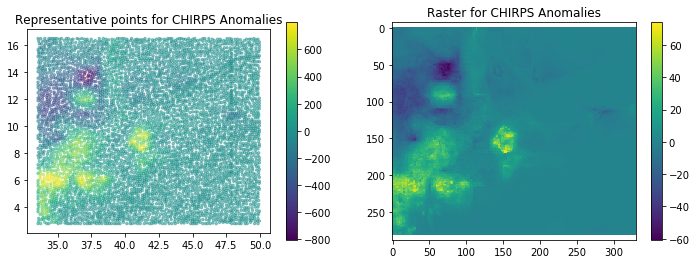

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
lims = plt.axis('equal')

gdf.plot(ax=axes[0],
         column='rainfall', 
         markersize=6, 
         alpha=0.5, 
         cmap='viridis',
         legend=True)


show(band, ax=axes[1], alpha=0.9)
chm_plot = axes[1].imshow(band,cmap='viridis')
fig.colorbar(chm_plot, ax=axes[1])

axes[0].set_title('Representative points for CHIRPS Anomalies')
axes[1].set_title('Raster for CHIRPS Anomalies')

## Aggregations

This is useful, except that the summation over rainfall leads us to have a nonsensical legend. Rainfall should be averaged across selected pixels, not summed (as we might do with population).

We can solve this by passing the `agg` arg to our `WindowedUnrasterizer`. This can take one of two values:

* `sum`
* `average`

The default behavior is to `sum` values across pixels to preserve the original pixel value. However, there are times such as with rainfall data, where we wish to `average` instead.

In [9]:
agg = 'average'
unrasterizer = unrasterize.WindowedUnrasterizer(mask_width=mask_width, threshold=threshold, agg=agg)
unrasterizer.select_representative_pixels(raster_data)
gdf = unrasterizer.to_geopandas(value_attribute_name='rainfall', crs=raster_data.crs)

Text(0.5, 1, 'Raster for CHIRPS Anomalies')

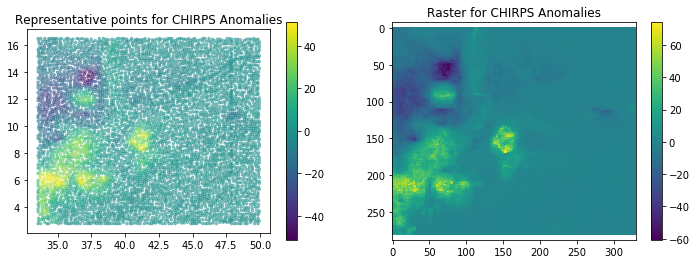

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
lims = plt.axis('equal')

gdf.plot(ax=axes[0],
         column='rainfall', 
         markersize=6, 
         alpha=0.5, 
         cmap='viridis',
         legend=True)


show(band, ax=axes[1], alpha=0.9)
chm_plot = axes[1].imshow(band,cmap='viridis')
fig.colorbar(chm_plot, ax=axes[1])

axes[0].set_title('Representative points for CHIRPS Anomalies')
axes[1].set_title('Raster for CHIRPS Anomalies')

Much better! Note that we do lose some of our extreme values through this process of averaging, which is to be expected. Also, it goes without saying but the original total pixel values from the raster will **not** be maintained:

In [11]:
print(f"The original sum of all pixels above the threshold is {np.sum(band[band > threshold])}.\n"\
      f"The sum of all points produced by unrasterize is {np.sum(unrasterizer.selected_values)}")

The original sum of all pixels above the threshold is 77359.0078125.
The sum of all points produced by unrasterize is 4915.1005859375
